<a href="https://colab.research.google.com/github/shabububu/ww2db_data/blob/master/20191125_ww2color_full_300epochs_eval3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Attempt to reproduce https://github.com/emilwallner/Coloring-greyscale-images/blob/master/Full-version/full_version.ipynb using photographs from http://ww2db.com

In [0]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing import image
from keras.engine import Layer
from keras.applications.inception_resnet_v2 import preprocess_input
from keras.layers import Conv2D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, merge, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, CSVLogger
from keras.models import Sequential, Model
from keras.layers.core import RepeatVector, Permute
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive') 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Set my drive path for convenience
my_drive = "drive/My Drive/Learning/CapstoneData/"

# Get training image path
train_path = os.path.join(my_drive, 'ww2db', '256', 'ww2db_20191102_256x256_a_1600_color')
!ls "$train_path" | wc -l

1600


In [0]:
# Get images
X = []
for filename in os.listdir(train_path):
    #print(os.path.join(train_path, filename))
    X.append(img_to_array(load_img(os.path.join(train_path, filename))))
X = np.array(X, dtype=float)

In [0]:
# Set up train and test data
split = 1500
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

In [0]:
#Load weights
inception = InceptionResNetV2(weights='imagenet', include_top=True)
inception.graph = tf.get_default_graph()

In [0]:
embed_input = Input(shape=(1000,))

#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)

#Fusion
fusion_output = RepeatVector(32 * 32)(embed_input) 
fusion_output = Reshape(([32, 32, 1000]))(fusion_output)
fusion_output = concatenate([encoder_output, fusion_output], axis=3) 
fusion_output = Conv2D(256, (1, 1), activation='relu', padding='same')(fusion_output) 

#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(fusion_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)

model = Model(inputs=[encoder_input, embed_input], outputs=decoder_output)

In [0]:
# Create results directory
import datetime

timestamp='{:%Y%m%d_%H%M%S}'.format(datetime.datetime.now())
result_path = os.path.join(my_drive, 'ww2db', 'results', "20191125_ww2color_full_300epochs_eval3_"+timestamp)
print("Result directory '{}'".format(result_path))
if not os.path.exists(result_path):
    print("Creating new directory: {}".format(result_path))
    tf.gfile.MkDir(result_path)
else:
    print("Directory already exists: {}".format(result_path))

!ls "$result_path"

Result directory 'drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521'
Creating new directory: drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521


In [0]:
def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode='constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    with inception.graph.as_default():
        embed = inception.predict(grayscaled_rgb_resized)
    return embed

# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

#Generate training data
batch_size = 50

def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        grayscaled_rgb = gray2rgb(rgb2gray(batch))
        embed = create_inception_embedding(grayscaled_rgb)
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        X_batch = X_batch.reshape(X_batch.shape+(1,))
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield ([X_batch, create_inception_embedding(grayscaled_rgb)], Y_batch)


# Generate Validation Set
Xtest_tmp = gray2rgb(rgb2gray(1.0/255*X[split:]))
Xtest_embed = create_inception_embedding(Xtest_tmp)
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))

Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128

# Train model      
tensorboard = TensorBoard(log_dir=os.path.join(result_path,'tensorboard_logs'))
#earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=0, mode='min')
mcp_save_acc = ModelCheckpoint(os.path.join(result_path,'weights.{epoch:03d}-{val_acc:.4f}-{val_loss:.4f}.hdf5'), save_best_only=True, monitor='val_acc', mode='max')
mcp_save_loss = ModelCheckpoint(os.path.join(result_path,'weights.{epoch:03d}-{val_acc:.4f}-{val_loss:.4f}.hdf5'), save_best_only=True, monitor='val_loss', mode='min')
csv_logger = CSVLogger(os.path.join(result_path,'log.csv'), separator=',', append=False)


model.compile(optimizer='rmsprop', loss='mse', metrics=['mse', 'accuracy'])
model.fit_generator(image_a_b_gen(batch_size), callbacks=[tensorboard, mcp_save_acc, mcp_save_loss, csv_logger], epochs=300, steps_per_epoch=30, validation_data=([Xtest, Xtest_embed], Ytest))






Epoch 1/300
30/30 [==============================] - 103s 3s/step - loss: 0.1861 - mean_squared_error: 0.1861 - acc: 0.5299 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_acc: 0.4472

Epoch 2/300
30/30 [==============================] - 92s 3s/step - loss: 0.0080 - mean_squared_error: 0.0080 - acc: 0.5500 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_acc: 0.4472
Epoch 3/300
30/30 [==============================] - 101s 3s/step - loss: 0.0080 - mean_squared_error: 0.0080 - acc: 0.5434 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_acc: 0.4472
Epoch 4/300
30/30 [==============================] - 99s 3s/step - loss: 0.0080 - mean_squared_error: 0.0080 - acc: 0.5475 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_acc: 0.4472
Epoch 5/300
30/30 [==============================] - 100s 3s/step - loss: 0.0083 - mean_squared_error: 0.0083 - acc: 0.5423 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - val_acc: 0.4472
Epoch 6/300
30/30 [=======

In [0]:
# Save last model (just in case)
model_json = model.to_json()
with open(os.path.join(result_path,'final-model.json'), "w") as json_file:
    json_file.write(model_json)
model.save_weights(os.path.join(result_path,'final-model.h5'))

In [0]:
!ls "$result_path"

final-model.h5			weights.047-0.6175-0.0067.hdf5
final-model.json		weights.060-0.5990-0.0067.hdf5
log.csv				weights.071-0.6222-0.0067.hdf5
tensorboard_logs		weights.074-0.6021-0.0067.hdf5
weights.001-0.4472-0.0082.hdf5	weights.082-0.5927-0.0066.hdf5
weights.002-0.4472-0.0080.hdf5	weights.096-0.5878-0.0065.hdf5
weights.012-0.4497-0.0080.hdf5	weights.097-0.6153-0.0065.hdf5
weights.013-0.4473-0.0080.hdf5	weights.099-0.6032-0.0064.hdf5
weights.017-0.4493-0.0080.hdf5	weights.101-0.6038-0.0064.hdf5
weights.018-0.5712-0.0080.hdf5	weights.104-0.6277-0.0065.hdf5
weights.023-0.4474-0.0079.hdf5	weights.116-0.6097-0.0063.hdf5
weights.026-0.4941-0.0075.hdf5	weights.118-0.6189-0.0063.hdf5
weights.028-0.4793-0.0074.hdf5	weights.134-0.6191-0.0063.hdf5
weights.030-0.4482-0.0073.hdf5	weights.147-0.6117-0.0062.hdf5
weights.034-0.5190-0.0073.hdf5	weights.154-0.6326-0.0067.hdf5
weights.038-0.6261-0.0071.hdf5	weights.170-0.6018-0.0062.hdf5
weights.041-0.6268-0.0069.hdf5	weights.182-0.6261-0.0062.hdf5
weight

In [0]:
# Load best model from training
# TODO: Figure out how to load it manually, instead of having to look up the best model by hand.
best_model_path=os.path.join(result_path,'weights.154-0.6326-0.0067.hdf5')
model.load_weights(best_model_path)

In [0]:
# Validation Set images
print(model.evaluate([Xtest, Xtest_embed], Ytest))

100/100 [==============================] - 1s 12ms/step
[0.0067024980112910275, 0.0067024980112910275, 0.6325993347167969]


In [0]:
# Now testing on black and white images without color ground truth
test_path = os.path.join(my_drive, 'ww2db', '256', 'ww2db_test_bw_256x256')

!ls "$test_path" | wc -l

26


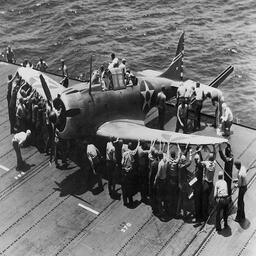

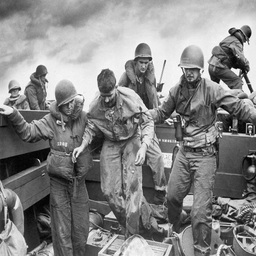

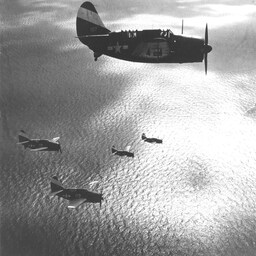

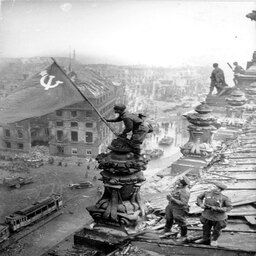

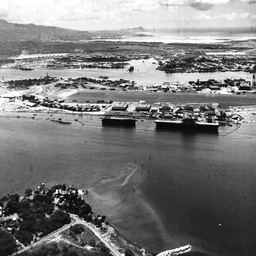

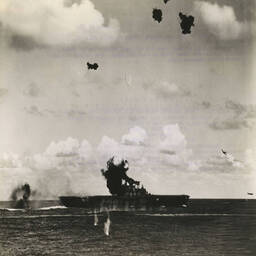

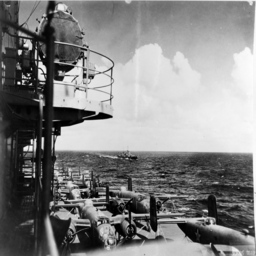

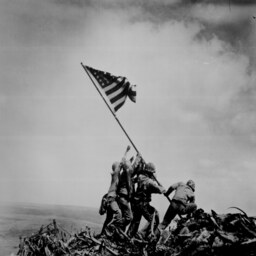

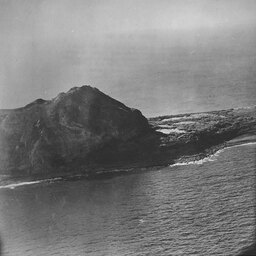

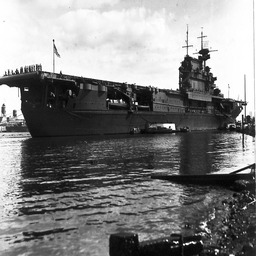

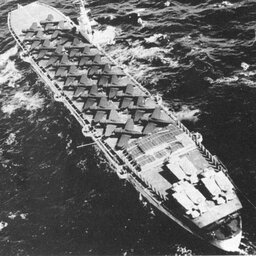

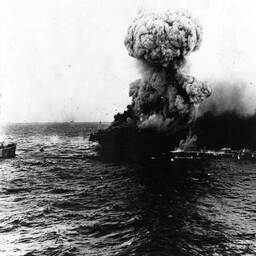

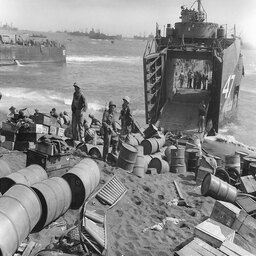

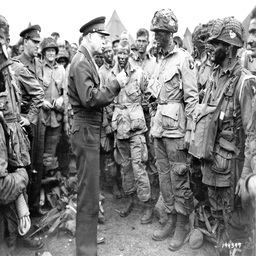

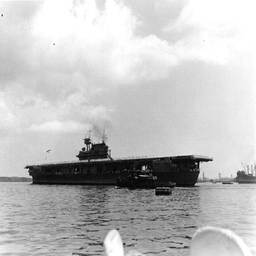

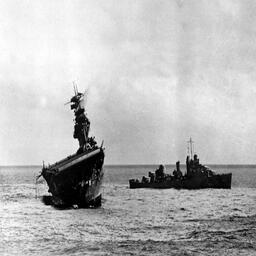

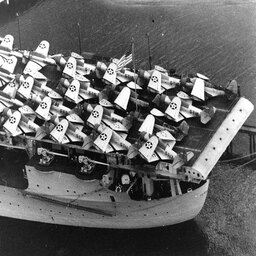

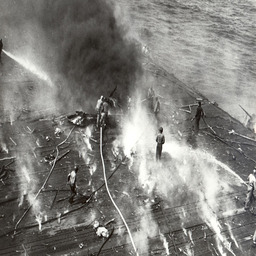

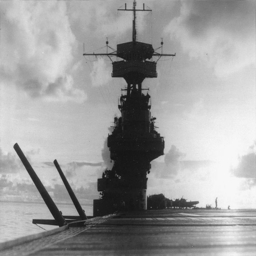

In [0]:
from IPython.display import Image, display

for filename in os.listdir(test_path):
    #print(os.path.join(test_path, filename))
    display(Image(os.path.join(test_path, filename)))

In [0]:
color_me = []
for filename in os.listdir(test_path):
    #print(os.path.join(test_path, filename))
    color_me.append(img_to_array(load_img(os.path.join(test_path, filename))))
color_me = np.array(color_me, dtype=float)
gray_me = gray2rgb(rgb2gray(1.0/255*color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0/255*color_me)[:,:,:,0]
color_me = color_me.reshape(color_me.shape+(1,))

In [0]:
# Test model
output = model.predict([color_me, color_me_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = color_me[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave(os.path.join(result_path, "img_"+str(i)+".png"), lab2rgb(cur))

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_0.png


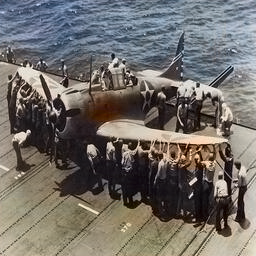

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_1.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_2.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_3.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_4.png


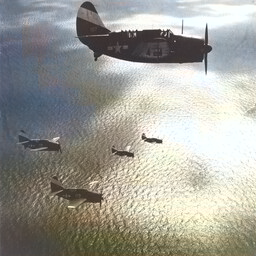

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_5.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_6.png


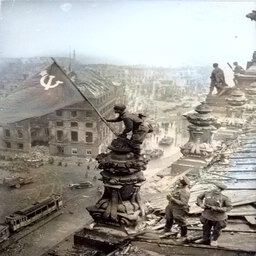

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_7.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_8.png


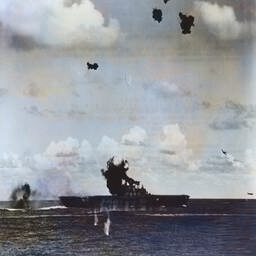

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_9.png


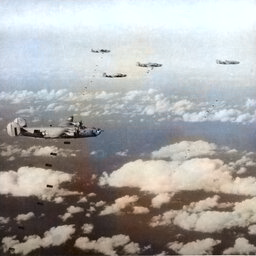

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_10.png


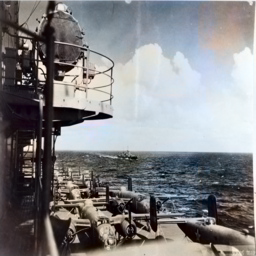

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_11.png


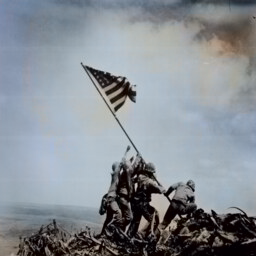

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_12.png


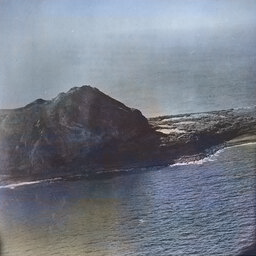

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_13.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_14.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_15.png


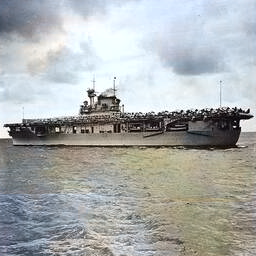

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_16.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_17.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_18.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_19.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_20.png


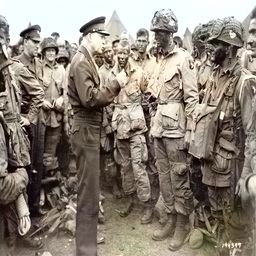

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_21.png


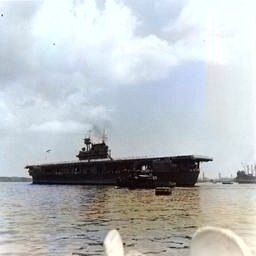

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_22.png


drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_23.png


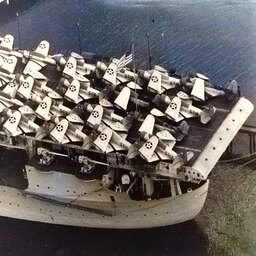

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_24.png


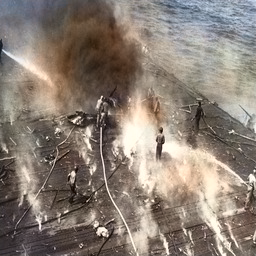

drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/img_25.png


In [0]:
for filename in os.listdir(result_path):
    if filename.endswith('.png'):
        print(os.path.join(result_path, filename))
        display(Image(os.path.join(result_path, filename)))

In [0]:
# Testing on held out colored set

test_path = os.path.join(my_drive, 'ww2db', '256', 'ww2db_20191102_256x256_a_test_122')

# Get evaluation images (non-validation)
eval_set = []
for filename in os.listdir(test_path):
    eval_set.append(img_to_array(load_img(os.path.join(test_path, filename))))
eval_set = np.array(eval_set, dtype=float)

eval_set_Y = rgb2lab(1.0/255*eval_set)[:,:,:,1:]
eval_set_Y = eval_set_Y / 128

eval_set_tmp = gray2rgb(rgb2gray(1.0/255*eval_set))
eval_set_embed = create_inception_embedding(eval_set_tmp)
eval_set_test = rgb2lab(1.0/255*eval_set)[:,:,:,0]
eval_set_test = eval_set_test.reshape(eval_set_test.shape+(1,))

print(model.evaluate([eval_set_test, eval_set_embed], eval_set_Y))

122/122 [==============================] - 0s 3ms/step
[0.007070727486041237, 0.007070727287562656, 0.6759228256882214]


In [0]:
# Test model
output=model.predict([eval_set_test, eval_set_embed])
output = output * 128

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:,:,0] = eval_set_test[i][:,:,0]
    cur[:,:,1:] = output[i]
    imsave(os.path.join(result_path, "img_test_"+str(i)+".png"), lab2rgb(cur))

In [0]:
import pandas as pd
result_path='drive/My Drive/Learning/CapstoneData/ww2db/results/20191125_ww2color_full_300epochs_eval3_20191125_082521/'
train_history = pd.read_csv(os.path.join(result_path, 'log.csv'))
train_history

epoch       acc      loss  ...   val_acc  val_loss  val_mean_squared_error
0        0  0.529927  0.186138  ...  0.447239  0.008157                0.008157
1        1  0.550002  0.008021  ...  0.447239  0.008025                0.008025
2        2  0.543440  0.008049  ...  0.447239  0.008143                0.008143
3        3  0.547525  0.007986  ...  0.447239  0.008090                0.008090
4        4  0.542323  0.008279  ...  0.447239  0.008153                0.008153
..     ...       ...       ...  ...       ...       ...                     ...
295    295  0.691374  0.004105  ...  0.575767  0.006998                0.006998
296    296  0.695348  0.004035  ...  0.617432  0.006558                0.006558
297    297  0.686442  0.004047  ...  0.599878  0.006693                0.006693
298    298  0.701745  0.003858  ...  0.580296  0.006824                0.006824
299    299  0.694425  0.004017  ...  0.596098  0.006797                0.006797

[300 rows x 7 columns]

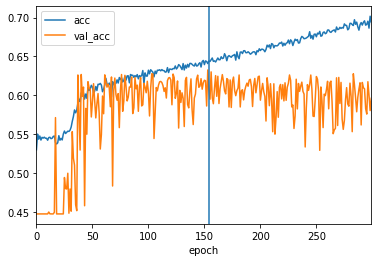

In [0]:
accuracy = train_history.plot.line(x='epoch',y=['acc', 'val_acc'])
accuracy.axvline(x=154)
a_fig = accuracy.get_figure()
a_fig.savefig(os.path.join(result_path, 'accuracy.jpg'))

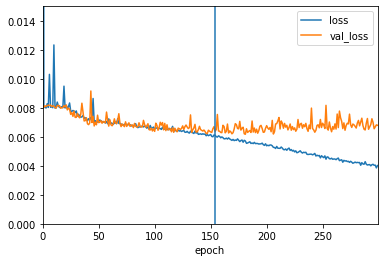

In [0]:
loss = train_history.plot.line(x='epoch',y=['loss', 'val_loss'],ylim=(0,0.015))
loss.axvline(x=154)
l_fig = loss.get_figure()
l_fig.savefig(os.path.join(result_path, 'loss.jpg'))

In [0]:
#TODO: Figure out how to use tensorboard in colab
#%tensorboard — logdir logs